Effect of Packet length to the spectrum

In [1]:
# add to path to acces cli 
import sys
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy import signal
from examples.seismic import Receiver
from devito import Operator
from sympy.polys.domains import domain


sys.path.insert(0, os.path.abspath("../cli"))
print(sys.path)
plt.rcParams['figure.figsize'] = (10, 10)  # Increases figure size
from simulation.sonar import Sonar, Sonar_v2
from simulation.utils import Bottom, positions_line, positions_half_circle, FlatBottom
from simulation import plotting
from simulation.sources import MultiFrequencySource, SineSource

['/home/bgd54/forge/devito/sonar-FWI/cli', '/home/bgd54/forge/devito/sonar-FWI/cli', '/home/bgd54/forge/devito/sonar-FWI/cli', '/home/bgd54/forge/devito/sonar-FWI/cli', '/usr/bin', '/home/bgd54/forge/devito/sonar-FWI/cli', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/bgd54/.local/lib/python3.10/site-packages', '/usr/lib/python3.10/site-packages', '/home/bgd54/.local/share/nvim/site/pack/packer/start/vim-jukit/helpers']


In [ ]:
def setup_beam(src, u, source_distance, alpha, dt, c):
    ns = src.coordinates.data.shape[0]
    for i in range(ns):
        latency = -np.cos(np.deg2rad(alpha)) * (i * source_distance / c)
        src.data[:, i] = np.roll(src.data[:, i], int(latency / dt))
    u.data.fill(0)

Setting up parameters of the simulation

In [ ]:
domain_size = (60,30) # (m, m)
f0 = 5. # kHz
v_env = 1.5 # km/s
ns = 128

source_distance = 0.02 # m
center_pos_rel = (.5, 0.) 
cy = (ns - 1) / 2 * source_distance

In [ ]:
f = np.arange(5, 8, 1) # kHz
alpha = np.arange(0, f.shape[0]*45, 45)+45 # deg

max_distance = math.sqrt((domain_size[0]/2)**2 + domain_size[1]**2)
t_end = max_distance / v_env
s2 = Sonar_v2(domain_size, np.max(f), v_env, FlatBottom(), t_end)

In [ ]:
src_coord = np.array(
    [(domain_size[0] - source_distance * ns) / 2, cy]
) + positions_line(stop_x=ns * source_distance, posy=source_distance, n=ns)
src = MultiFrequencySource(
    name="src",
    grid=s2.model.grid,
    npoint=ns,
    f0=f,
    alpha=alpha,
    packet_l=32,
    time_range=s2.time_range,
    coordinates_data=src_coord,
)
src.apply_latency_profile(v_env)

rec = Receiver(
    name="rec",
    grid=s2.model.grid,
    time_range=s2.time_range,
    npoint=180,
    coordinates=positions_half_circle(15.0, 30.0, cy),
)
s2.set_source(src, rec)
s2.finalize()

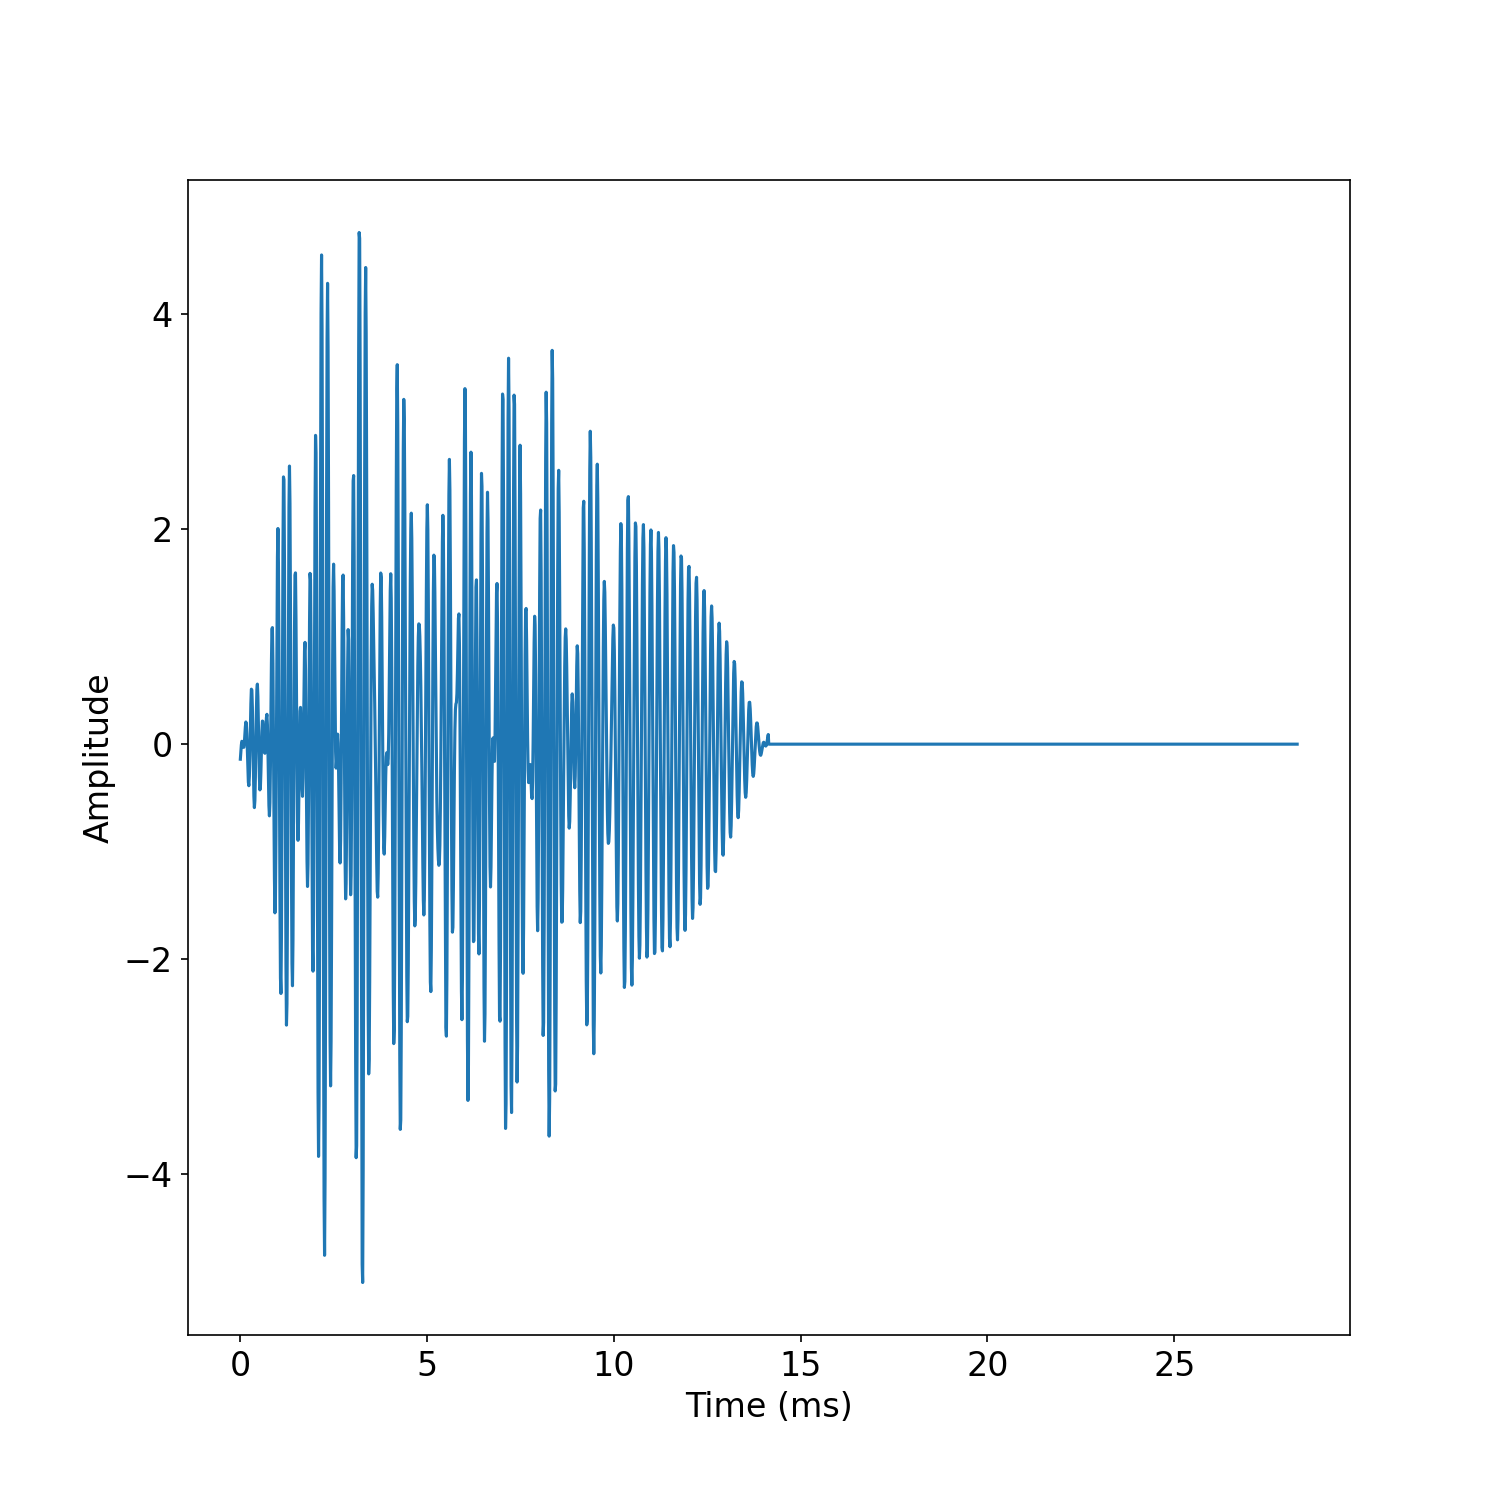

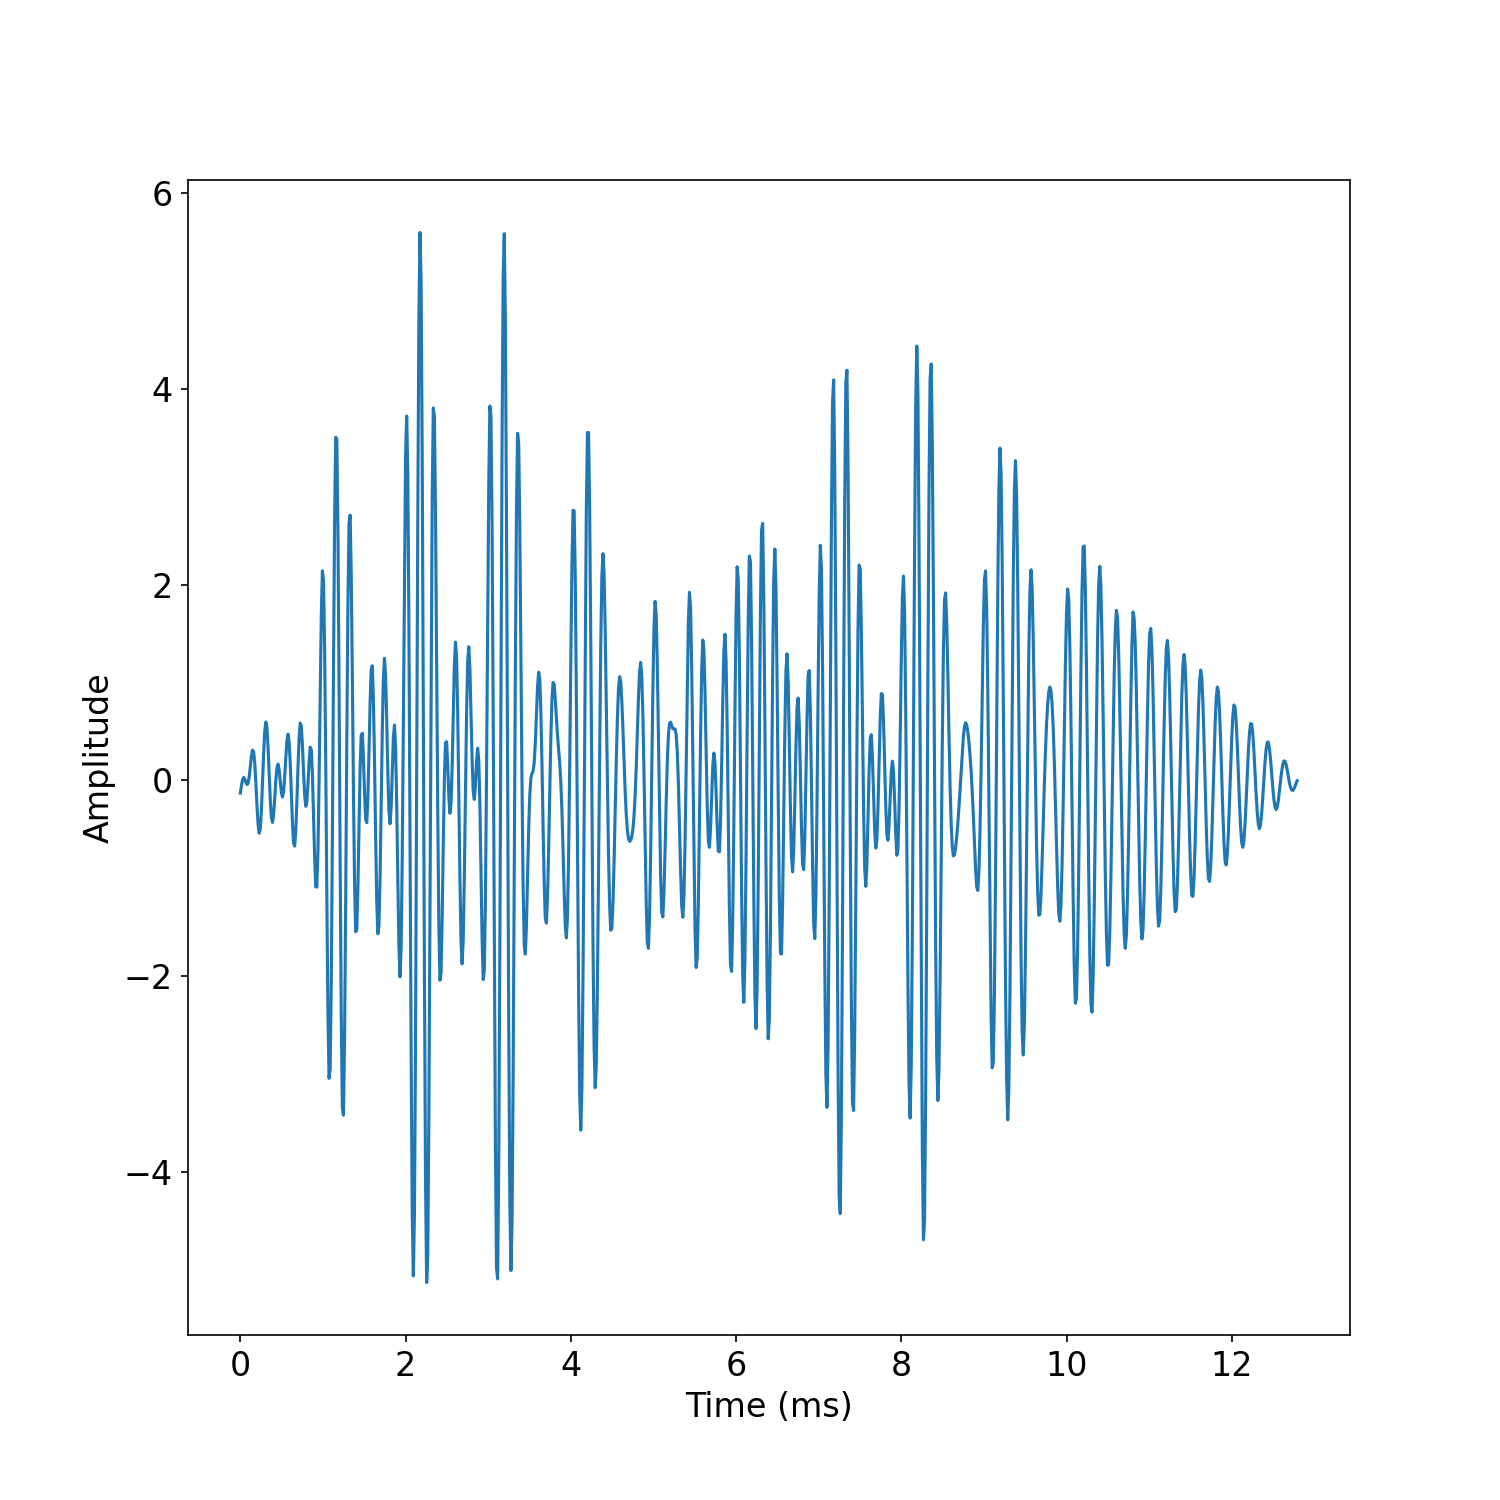

In [2]:
wave = src.data[:, 0]

plt.plot(s2.time_range.time_values, wave)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

packet = src.signal_packet
plt.plot(s2.time_range.time_values[:packet.shape[0]], packet)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

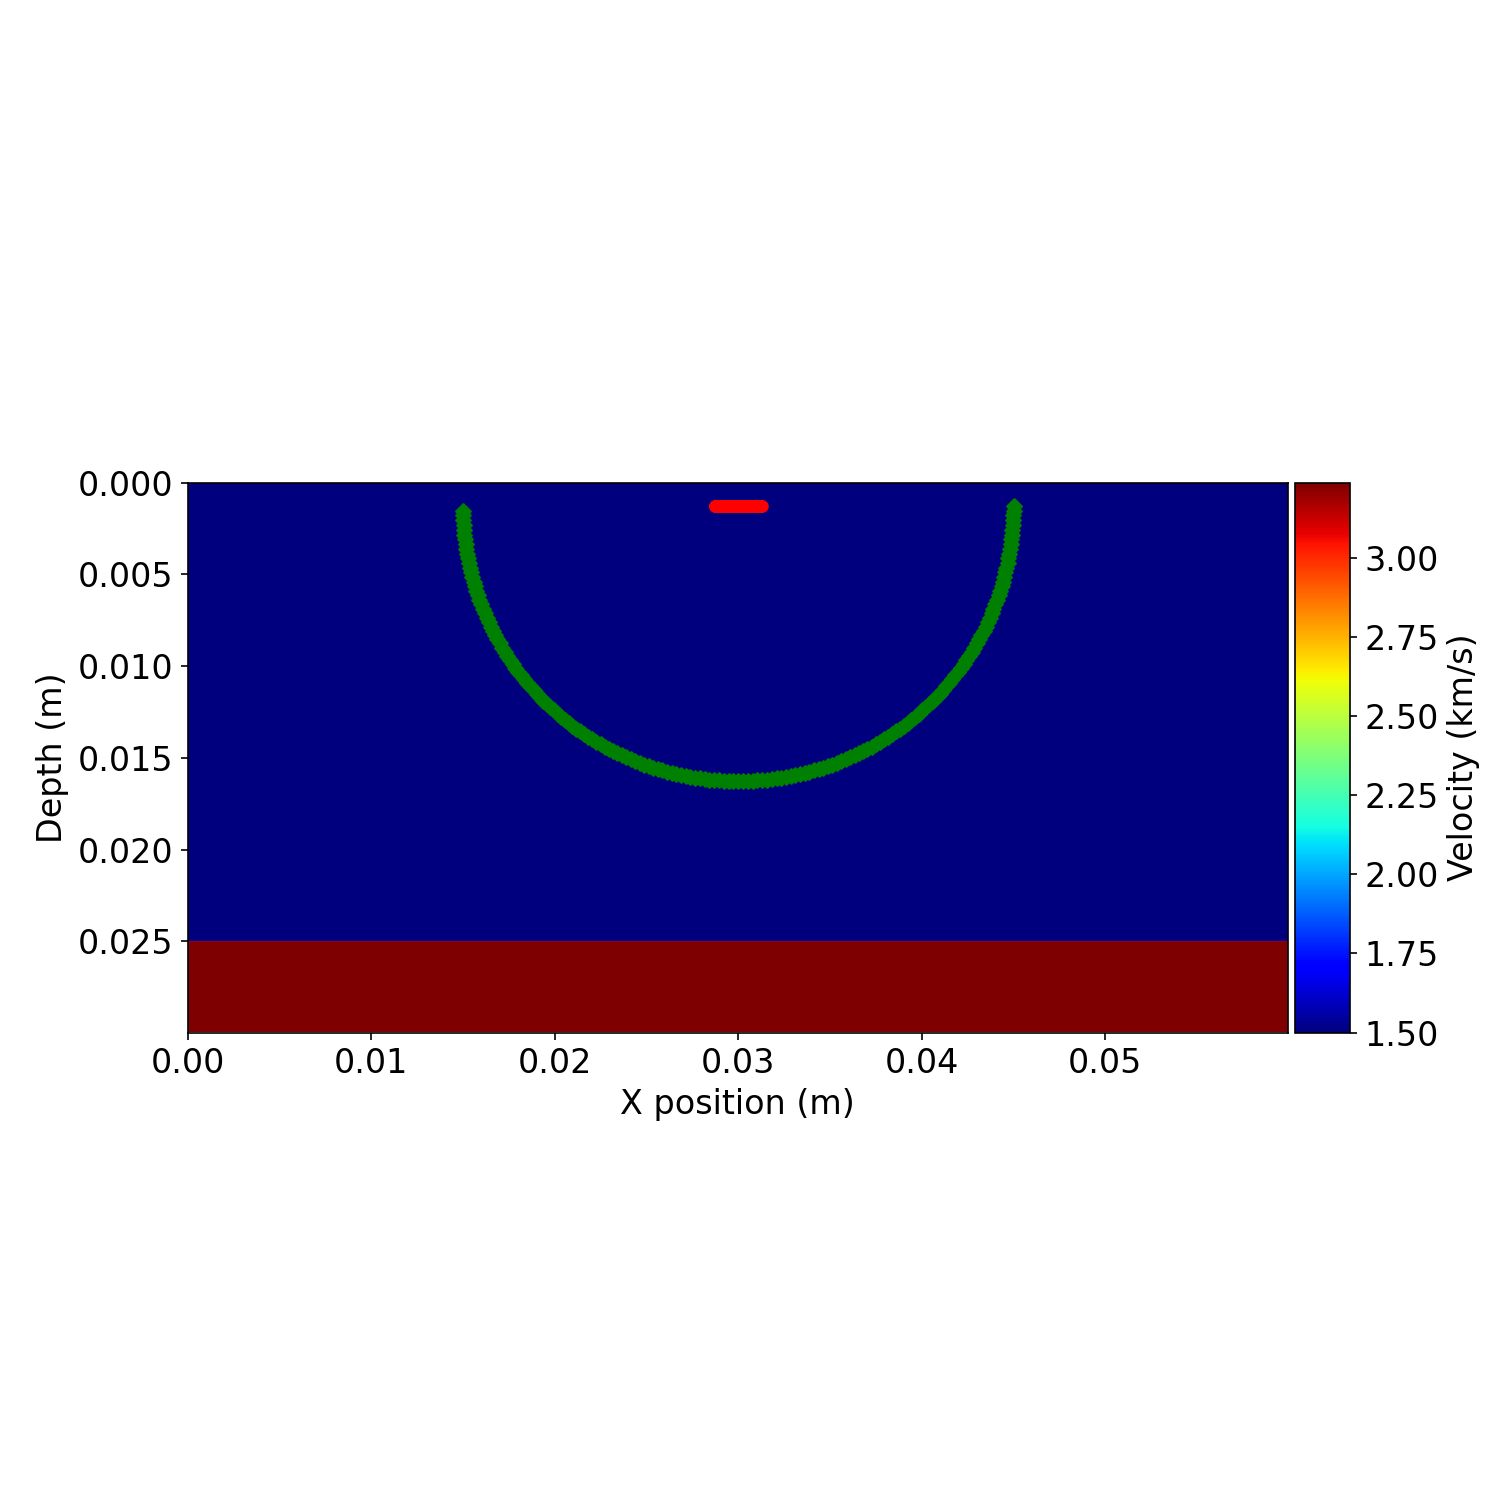

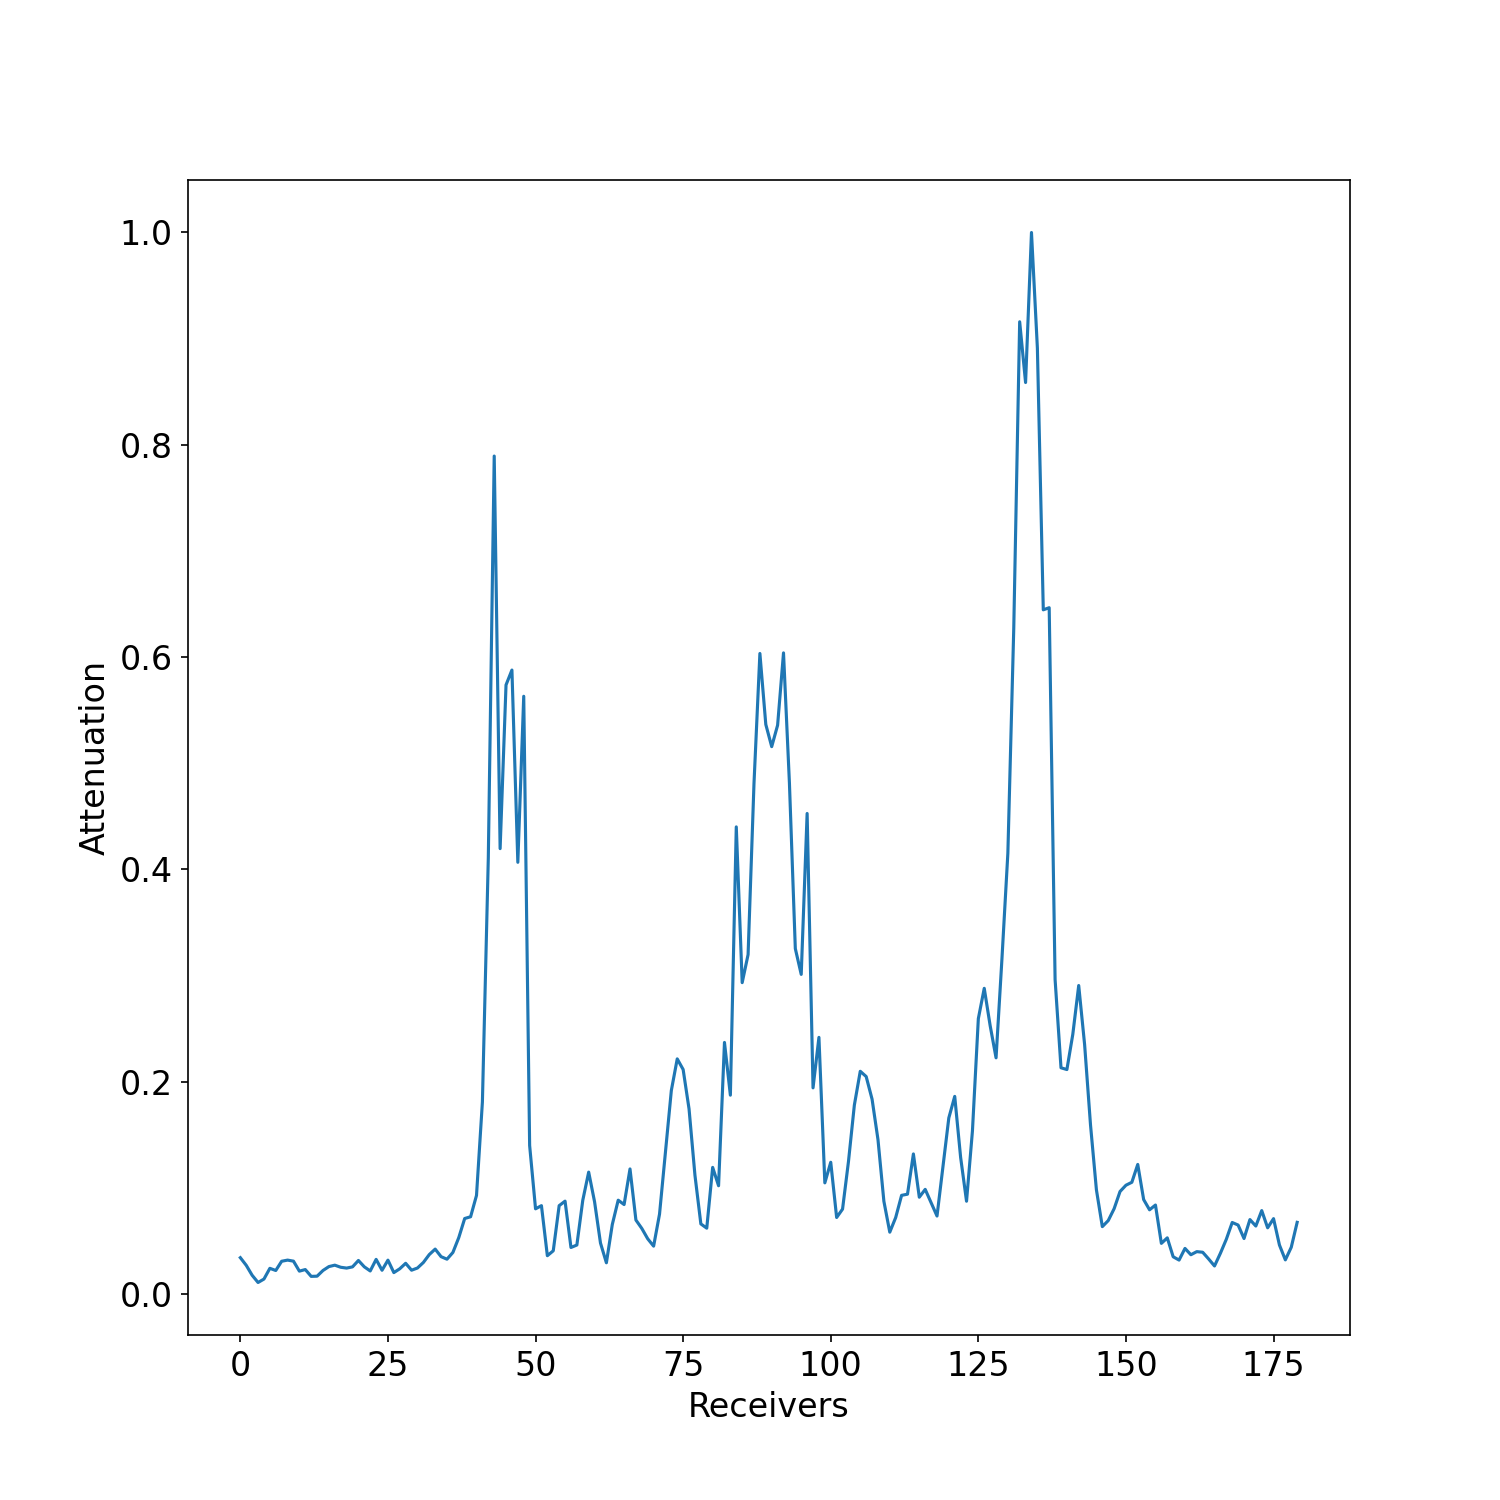

In [3]:
assert isinstance(s2.op, Operator) and isinstance(s2.rec, Receiver)
s2.op(time=s2.time_range.num - 2, dt=s2.model.critical_dt)

In [ ]:
plotting.plot_velocity(s2.model, s2.src.coordinates.data, s2.rec.coordinates.data)

plotting.plot_attenuation(s2.rec.data, 1600)

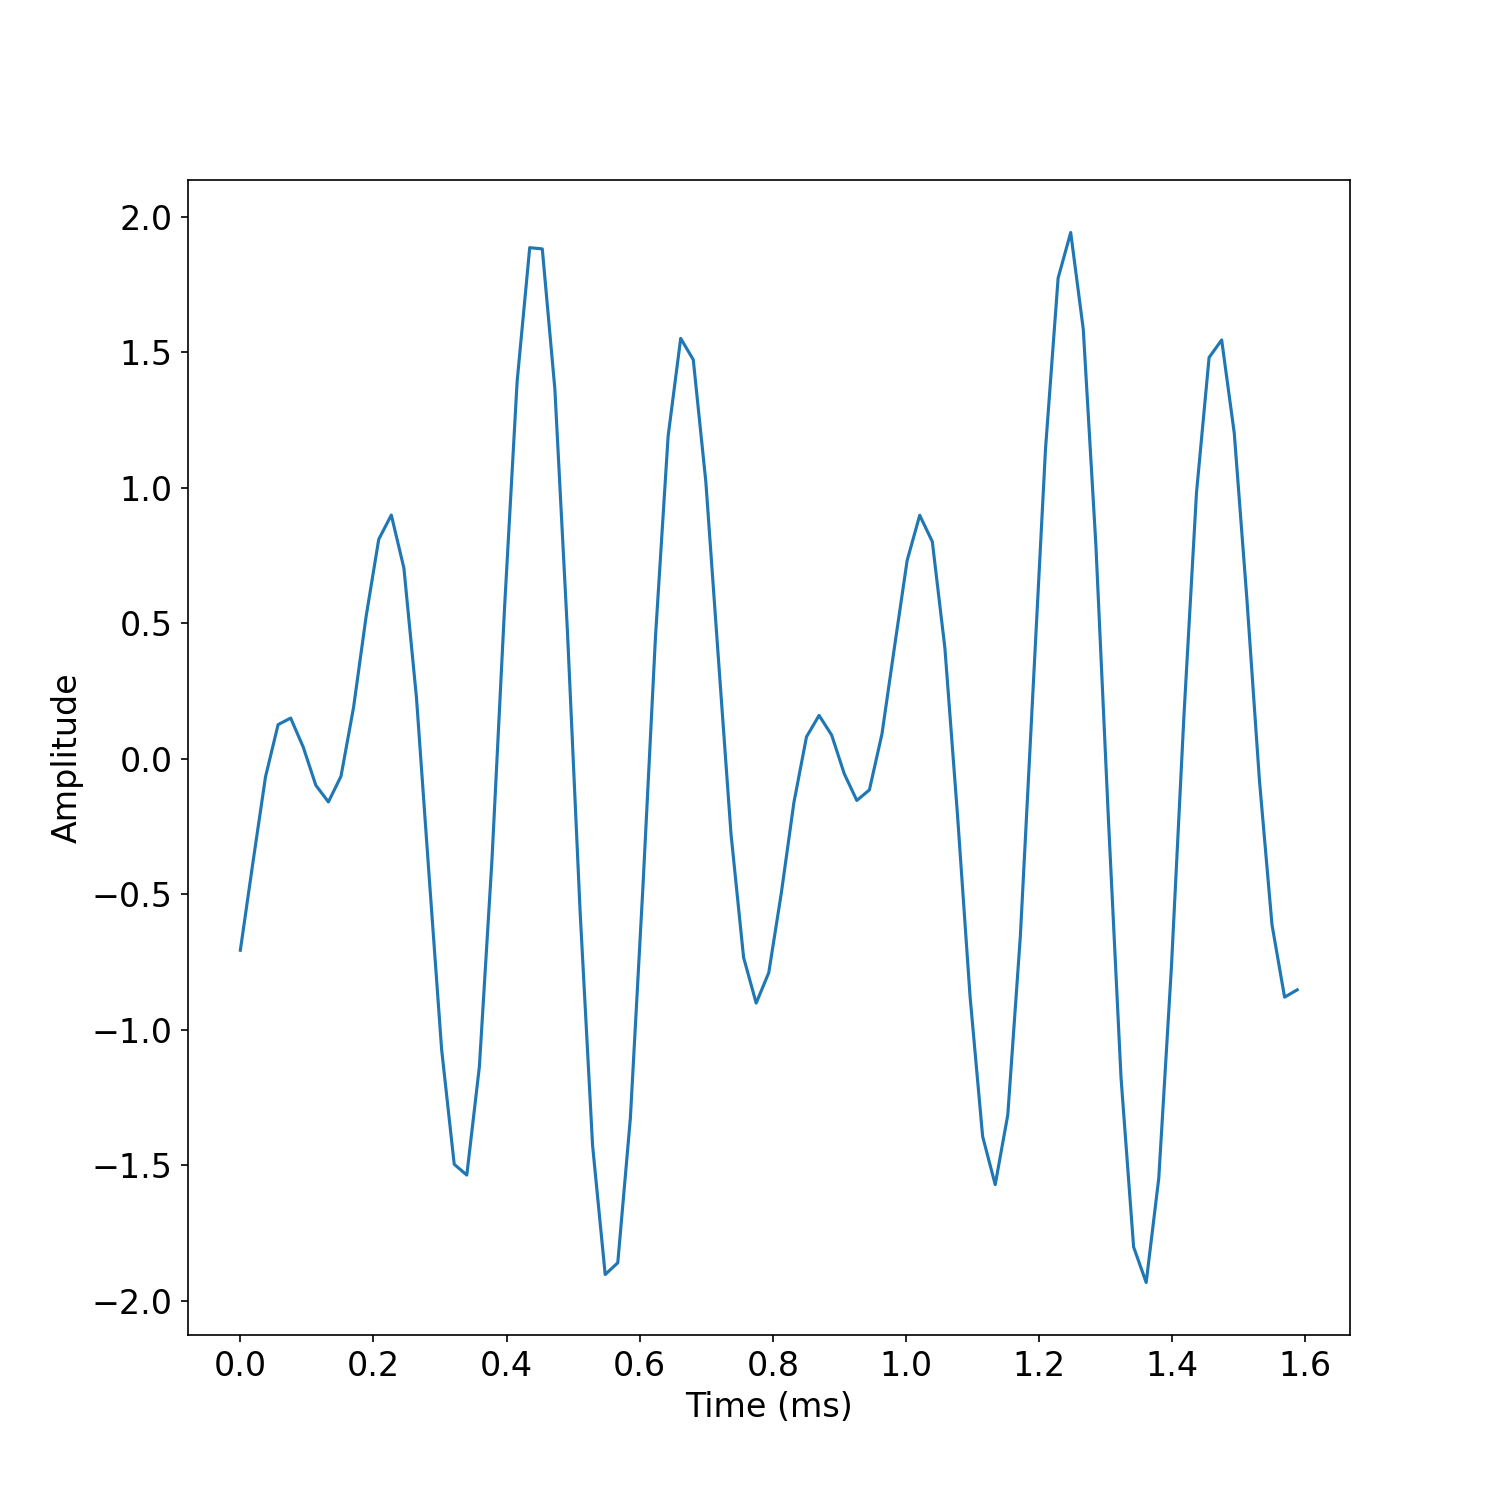

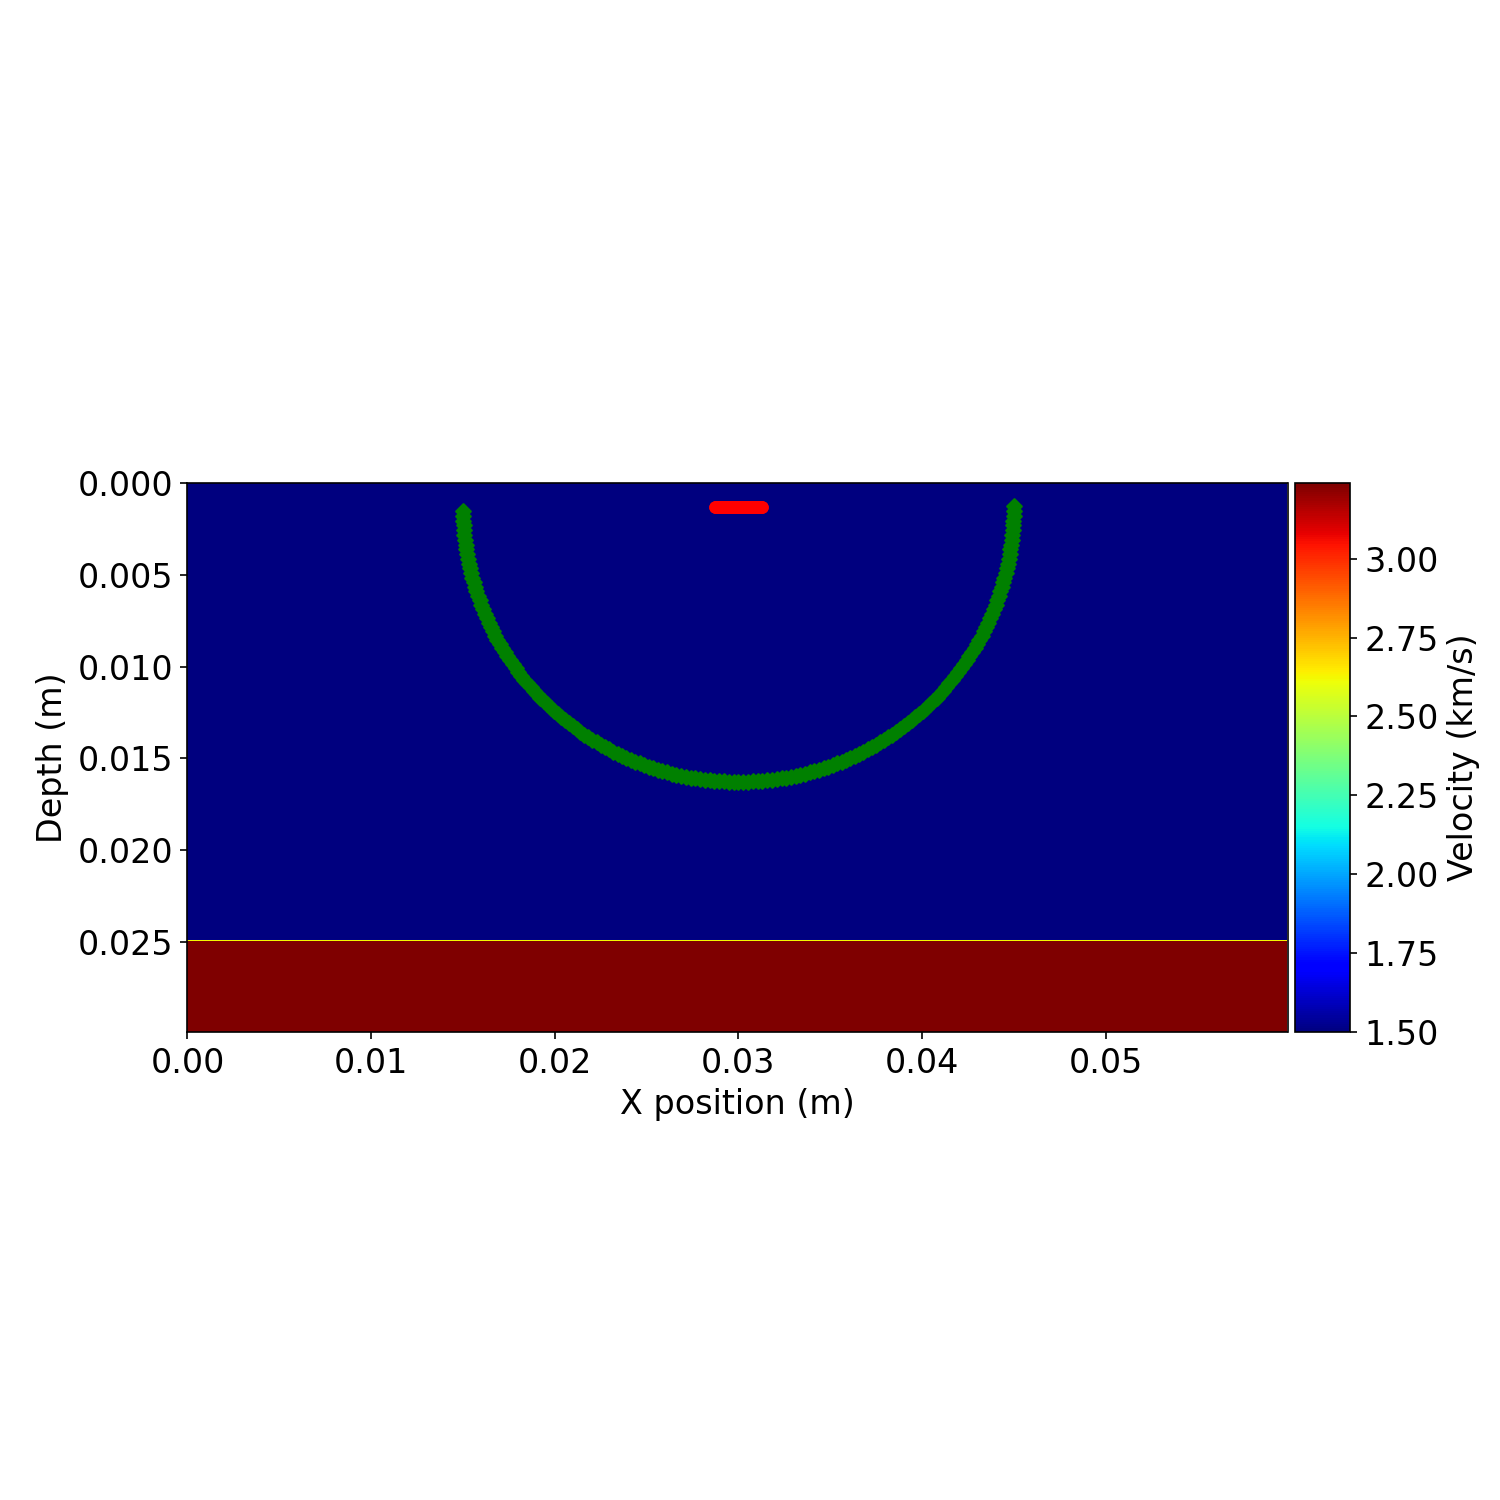

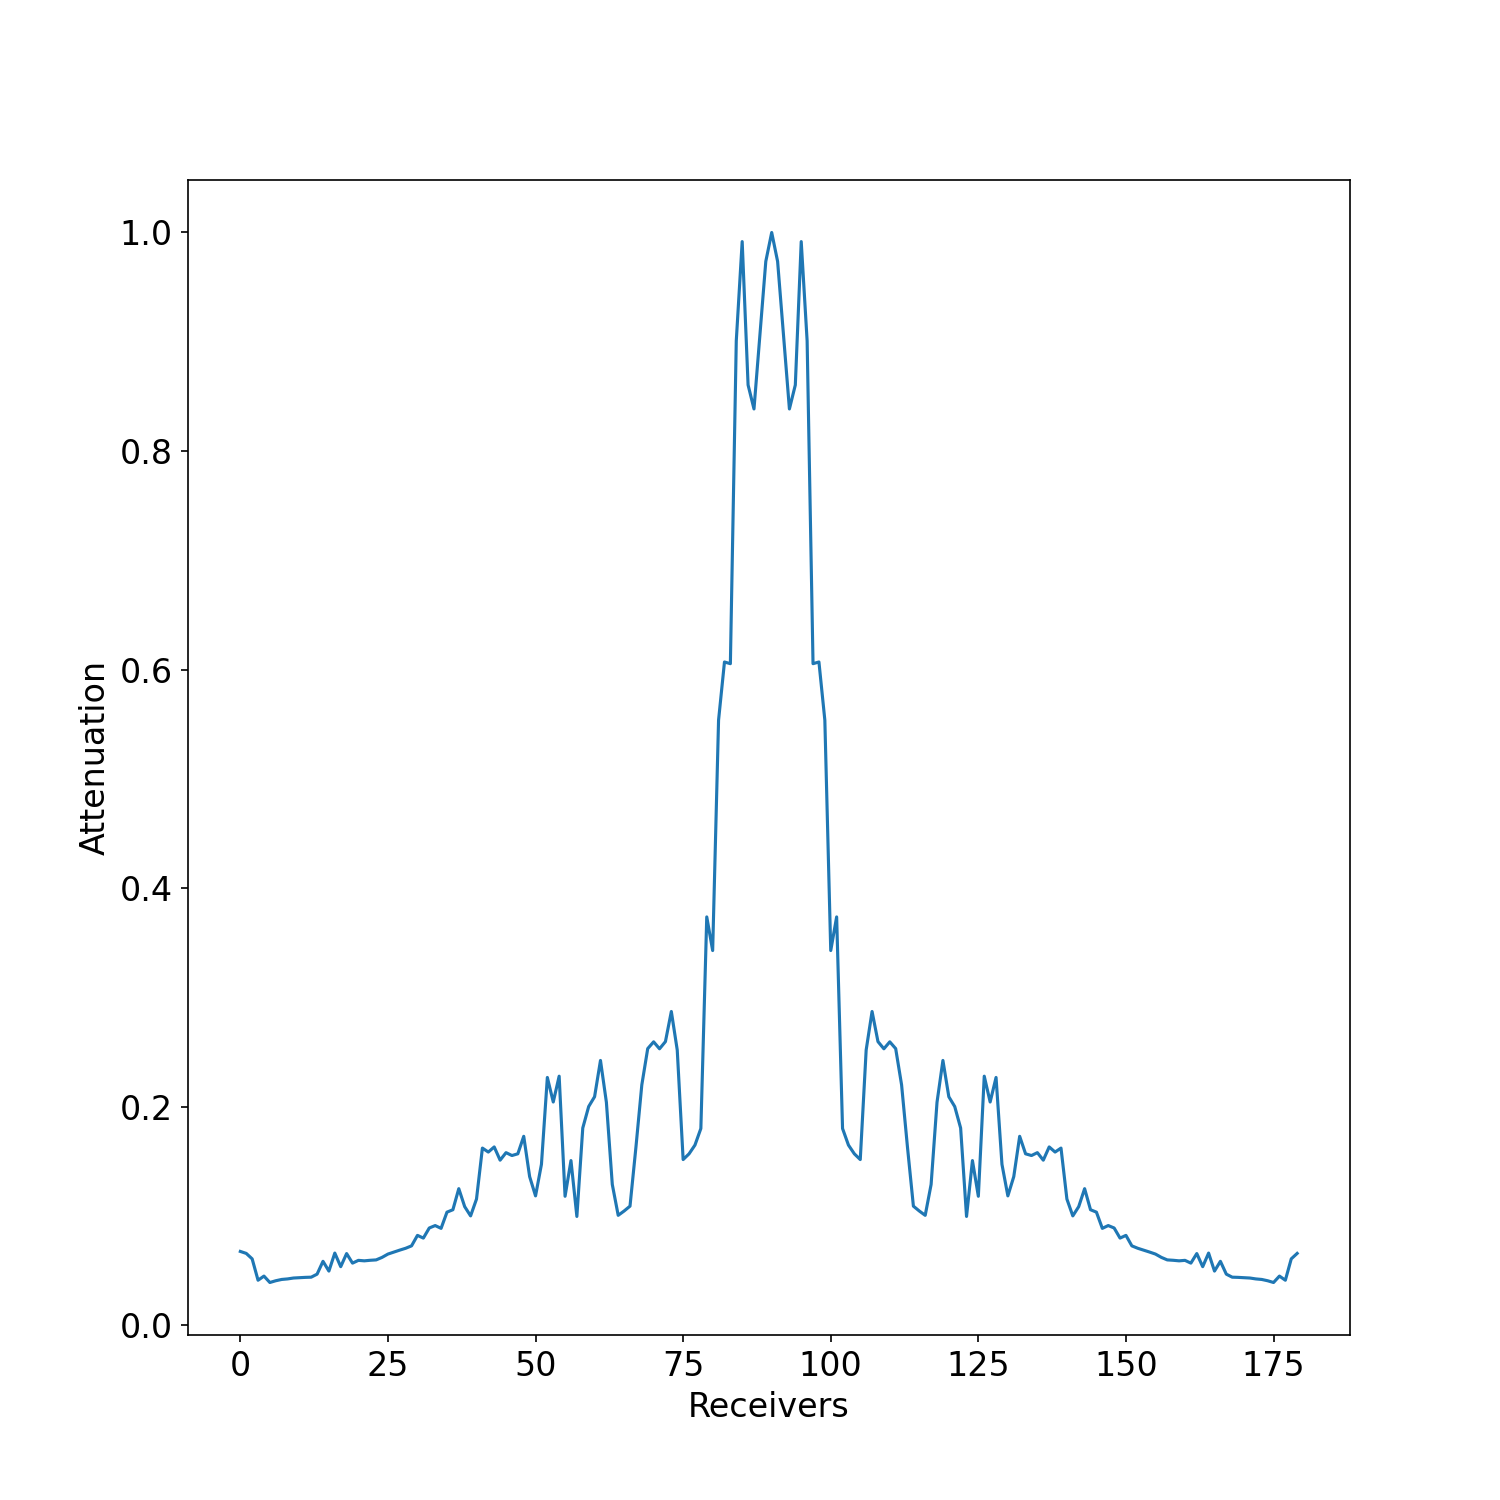

In [4]:
s3 = Sonar_v2(domain_size, f0, v_env, FlatBottom(), t_end)
src3 = SineSource(
    name="src",
    grid=s3.model.grid,
    npoint=ns,
    f0=f0,
    time_range=s3.time_range,
    coordinates_data=src_coord,
)
rec3 = Receiver(
    name="rec",
    grid=s3.model.grid,
    time_range=s3.time_range,
    npoint=180,
    coordinates=positions_half_circle(15.0, 30.0, cy),
)
s3.set_source(src3, rec3)
s3.finalize()

packet = src3.signal_packet
plt.plot(s3.time_range.time_values[:packet.shape[0]], packet)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

assert isinstance(s3.op, Operator) and isinstance(s3.rec, Receiver)
s3.op(time=s3.time_range.num - 2, dt=s3.model.critical_dt)

plotting.plot_velocity(s3.model, s3.src.coordinates.data, s3.rec.coordinates.data)

plotting.plot_attenuation(s3.rec.data, 1600)

In [ ]:
# yf = fft(wave)
# xf = fftfreq(len(time_values.time_values), s.model.critical_dt*1e-3)

# on = list(map(lambda x: x > 0 and x < 400e3, xf))

# plt.plot(xf[on], np.abs(yf[on]))
# plt.show()


#f0 = 8*1e3
#dt = s.model.critical_dt
#print('sampling freq ' + str(1/dt))
#bandpass = signal.butter(10, [4,6], 'bandpass', fs=1/dt, output='sos')

#time = time_values.time_values[0:2*600]
#to_filter = s.src.data[:2*600,0]
##time = src.time_values[:cut]
##to_filter = rec.data[:cut,64]
#filtered = signal.sosfilt(bandpass, to_filter)
#plt.figure()
#plt.plot(time,to_filter)
#plt.plot(time,filtered)